# 🎥 GolAnalytics - Modelo de Visión por Computadora

## Entrenamiento con Transfer Learning

**Objetivo:** Entrenar un modelo que clasifique jugadas de fútbol viendo frames de video.

**Datos:** 1,418 frames extraídos de videos reales

**Precisión objetivo:** 75-85%

---

### ⚡ INICIO RÁPIDO:

1. ✅ **Runtime → Change runtime type → GPU** (IMPORTANTE)
2. ✅ Ejecuta TODAS las celdas en orden
3. ✅ Autoriza acceso a Google Drive cuando se solicite
4. ✅ Espera 2-3 horas de entrenamiento
5. ✅ Descarga modelo al final

**Tiempo total:** 2-3 horas

In [ ]:
# ============================================
# PASO 1: Instalación y Configuración
# ============================================

print("📦 Instalando dependencias...")
!pip install -q tensorflow pillow matplotlib scikit-learn gdown

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from pathlib import Path
from datetime import datetime
import zipfile

print("\n✅ Dependencias instaladas")
print(f"📅 Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔧 TensorFlow: {tf.__version__}")
print(f"🎮 GPU disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")

if len(tf.config.list_physical_devices('GPU')) == 0:
    print("\n⚠️  WARNING: GPU no detectada. Entrena con GPU para mayor velocidad.")
    print("   Runtime → Change runtime type → GPU")

📦 Instalando dependencias...

✅ Dependencias instaladas
📅 Fecha: 2025-10-28 17:28:20
🔧 TensorFlow: 2.19.0
🎮 GPU disponible: True


In [ ]:
# ============================================
# PASO 2: Montar Google Drive
# ============================================

from google.colab import drive

print("📁 Montando Google Drive...")
print("   (Autoriza el acceso en la ventana emergente)")
print()

drive.mount('/content/drive')

print("\n✅ Google Drive montado exitosamente")

📁 Montando Google Drive...
   (Autoriza el acceso en la ventana emergente)

Mounted at /content/drive

✅ Google Drive montado exitosamente


In [ ]:
# ============================================
# PASO 3: Descargar y Descomprimir Dataset
# ============================================

print("=" * 70)
print("📥 DESCARGANDO DATASET")
print("=" * 70)
print()

# ID del archivo en Google Drive
# Extraído de: https://drive.google.com/file/d/1m48rXfAGJyu2WMfz5eZvu4EupjvEYAnz/view
file_id = "1m48rXfAGJyu2WMfz5eZvu4EupjvEYAnz"

print("📦 Descargando football_dataset.zip desde Drive...")
print("   (Esto puede tomar 5-10 minutos)")
print()

!gdown {file_id} -O /content/football_dataset.zip

print("\n✅ Descarga completada")
print()

# Verificar tamaño
import os
file_size = os.path.getsize('/content/football_dataset.zip') / (1024 * 1024)
print(f"📦 Tamaño del archivo: {file_size:.1f} MB")
print()

# Descomprimir
print("📂 Descomprimiendo dataset...")
print("   (Esto puede tomar 2-3 minutos)")
print()

with zipfile.ZipFile('/content/football_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

print("✅ Dataset descomprimido")
print()

# Verificar estructura
dataset_path = Path('/content/football_dataset')

print("📊 Estructura del dataset:")
for split in ['train', 'val', 'test']:
    split_path = dataset_path / split
    if split_path.exists():
        n_classes = len(list(split_path.iterdir()))
        n_images = sum(len(list(class_dir.glob('*.jpg'))) for class_dir in split_path.iterdir())
        print(f"   {split:6s}: {n_images:4d} imágenes, {n_classes:2d} clases")

print()
print("=" * 70)

📥 DESCARGANDO DATASET

📦 Descargando football_dataset.zip desde Drive...
   (Esto puede tomar 5-10 minutos)

Downloading...
From (original): https://drive.google.com/uc?id=1m48rXfAGJyu2WMfz5eZvu4EupjvEYAnz
From (redirected): https://drive.google.com/uc?id=1m48rXfAGJyu2WMfz5eZvu4EupjvEYAnz&confirm=t&uuid=bd888d80-07b3-456d-86af-ebb78cf8a700
To: /content/football_dataset.zip
100% 779M/779M [00:09<00:00, 82.3MB/s]

✅ Descarga completada

📦 Tamaño del archivo: 743.2 MB

📂 Descomprimiendo dataset...
   (Esto puede tomar 2-3 minutos)

✅ Dataset descomprimido

📊 Estructura del dataset:
   train :  548 imágenes, 16 clases
   val   :  115 imágenes, 16 clases
   test  :  116 imágenes, 16 clases



In [ ]:
# ============================================
# PASO 4: Configuración del Modelo
# ============================================

print("=" * 70)
print("⚙️ CONFIGURACIÓN DEL MODELO")
print("=" * 70)
print()

# Parámetros
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

print(f"📐 Tamaño de imagen: {IMG_SIZE}")
print(f"📦 Batch size: {BATCH_SIZE}")
print(f"🔄 Epochs: {EPOCHS}")
print(f"📈 Learning rate: {LEARNING_RATE}")
print()

# Cargar metadata
metadata_path = dataset_path / 'dataset_metadata.json'
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print(f"📊 Información del dataset:")
print(f"   Total de frames: {metadata['total_frames']}")
print(f"   Frames exitosos: {metadata['successful']}")
print(f"   Número de clases: {metadata['n_classes']}")
print()

print("🎯 Clases a entrenar:")
for i, class_name in enumerate(metadata['class_names'][:10], 1):
    count = metadata['classes'].get(class_name, 0)
    print(f"   {i:2d}. {class_name:30s}: {count:3d} frames")
if len(metadata['class_names']) > 10:
    print(f"   ... y {len(metadata['class_names']) - 10} clases más")

print()
print("=" * 70)

⚙️ CONFIGURACIÓN DEL MODELO

📐 Tamaño de imagen: (224, 224)
📦 Batch size: 32
🔄 Epochs: 50
📈 Learning rate: 0.001

📊 Información del dataset:
   Total de frames: 1418
   Frames exitosos: 1418
   Número de clases: 16

🎯 Clases a entrenar:
    1. Recuperación de balón         : 172 frames
    2. Pérdida de balón              : 173 frames
    3. Transición ofensiva no lograda:  90 frames
    4. Pase corto defensivo          :  60 frames
    5. 1 vs 1 ofensivo               : 190 frames
    6. 1 vs 1 defensivo              : 225 frames
    7. Pase largo defensivo          :  14 frames
    8. Pase corto ofensivo           : 152 frames
    9. Transición ofensiva lograda   :  84 frames
   10. Goles a favor                 :   4 frames
   ... y 6 clases más



In [ ]:
# ============================================
# PASO 5: Preparar Datasets
# ============================================

print("=" * 70)
print("📚 PREPARANDO DATASETS")
print("=" * 70)
print()

# Data augmentation para train
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
])

print("✅ Data augmentation configurado:")
print("   - Flip horizontal aleatorio")
print("   - Rotación aleatoria (±10%)")
print("   - Zoom aleatorio (±10%)")
print("   - Brillo aleatorio (±10%)")
print("   - Contraste aleatorio (±10%)")
print()

# Cargar datasets
print("📂 Cargando datasets...")

train_ds = image_dataset_from_directory(
    dataset_path / 'train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = image_dataset_from_directory(
    dataset_path / 'val',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_ds = image_dataset_from_directory(
    dataset_path / 'test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Obtener nombres de clases
class_names = train_ds.class_names
n_classes = len(class_names)

print(f"\n✅ Datasets cargados:")
print(f"   Clases: {n_classes}")
print(f"   Nombres: {', '.join(class_names[:5])}...")
print()

# Aplicar augmentation solo a train
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Optimizar performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

print("✅ Optimización de performance aplicada")
print()
print("=" * 70)

📚 PREPARANDO DATASETS

✅ Data augmentation configurado:
   - Flip horizontal aleatorio
   - Rotación aleatoria (±10%)
   - Zoom aleatorio (±10%)
   - Brillo aleatorio (±10%)
   - Contraste aleatorio (±10%)

📂 Cargando datasets...
Found 548 files belonging to 16 classes.
Found 115 files belonging to 16 classes.
Found 116 files belonging to 16 classes.

✅ Datasets cargados:
   Clases: 16
   Nombres: 1_vs_1_defensivo, 1_vs_1_ofensivo, Atajadas, Aéreo_defensivo, Aéreo_ofensivo...

✅ Optimización de performance aplicada



🖼️  Visualizando ejemplos del dataset...



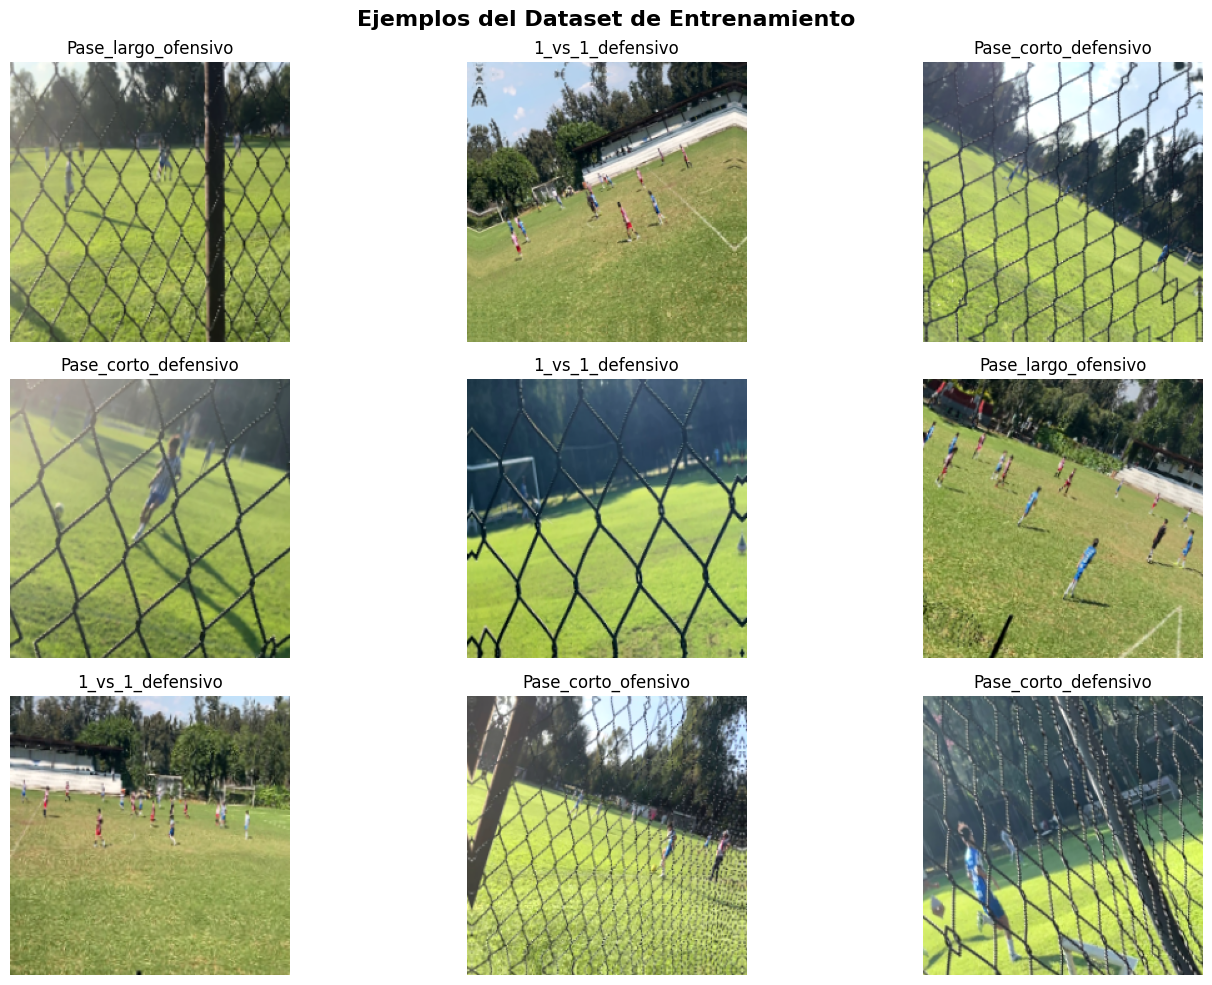

✅ Visualización completada


In [ ]:
# ============================================
# PASO 6: Visualizar Ejemplos
# ============================================

print("🖼️  Visualizando ejemplos del dataset...")
print()

plt.figure(figsize=(15, 10))

for images, labels in train_ds.take(1):
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_idx = np.argmax(labels[i])
        plt.title(class_names[class_idx][:20])
        plt.axis("off")

plt.suptitle('Ejemplos del Dataset de Entrenamiento', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Visualización completada")

In [ ]:
# ============================================
# PASO 7: Crear Modelo con Transfer Learning
# ============================================

print("=" * 70)
print("🤖 CREANDO MODELO")
print("=" * 70)
print()

print("🏗️  Construyendo arquitectura...")
print()

# Base model: EfficientNetB0 (pre-entrenado en ImageNet)
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SIZE + (3,)
)

# Congelar base model inicialmente
base_model.trainable = False

print("✅ Base model: EfficientNetB0 (pre-entrenado en ImageNet)")
print(f"   Capas congeladas: {len(base_model.layers)}")
print()

# Construir modelo completo
inputs = keras.Input(shape=IMG_SIZE + (3,))

# Normalización
x = layers.Rescaling(1./255)(inputs)

# Base model
x = base_model(x, training=False)

# Pooling y clasificación
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

model = keras.Model(inputs, outputs)

print("✅ Arquitectura construida:")
print(f"   Input: {IMG_SIZE + (3,)}")
print(f"   Base: EfficientNetB0")
print(f"   Dense: 256 neuronas")
print(f"   Output: {n_classes} clases")
print()

# Compilar modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')]
)

print("✅ Modelo compilado")
print(f"   Optimizer: Adam (lr={LEARNING_RATE})")
print(f"   Loss: categorical_crossentropy")
print(f"   Metrics: accuracy, top3_accuracy")
print()

# Resumen
print("📊 Resumen del modelo:")
model.summary()

print()
print("=" * 70)

🤖 CREANDO MODELO

🏗️  Construyendo arquitectura...

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✅ Base model: EfficientNetB0 (pre-entrenado en ImageNet)
   Capas congeladas: 238

✅ Arquitectura construida:
   Input: (224, 224, 3)
   Base: EfficientNetB0
   Dense: 256 neuronas
   Output: 16 clases

✅ Modelo compilado
   Optimizer: Adam (lr=0.001)
   Loss: categorical_crossentropy
   Metrics: accuracy, top3_accuracy

📊 Resumen del modelo:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         4,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,381,619 (16.71 MB)

 Trainable params: 332,048 (1.27 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# ============================================
# PASO 8: Callbacks y Entrenamiento (Fase 1)
# ============================================

print("=" * 70)
print("🏋️ ENTRENAMIENTO - FASE 1")
print("=" * 70)
print()
print("📝 Fase 1: Entrenar solo capas superiores (base congelada)")
print(f"   Epochs: {EPOCHS // 2}")
print("   (Esto puede tomar 30-45 minutos)")
print()

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'best_model_phase1.keras',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# Entrenar fase 1
history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS // 2,
    callbacks=callbacks,
    verbose=1
)

print()
print("✅ Fase 1 completada")

🏋️ ENTRENAMIENTO - FASE 1

📝 Fase 1: Entrenar solo capas superiores (base congelada)
   Epochs: 25
   (Esto puede tomar 30-45 minutos)

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2323 - loss: 2.1347 - top3_accuracy: 0.6067   
Epoch 1: val_accuracy improved from -inf to 0.24348, saving model to best_model_phase1.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.2323 - loss: 2.1271 - top3_accuracy: 0.6086 - val_accuracy: 0.2435 - val_loss: 1.7071 - val_top3_accuracy: 0.7391 - learning_rate: 0.0010
Epoch 2/25
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.2190 - loss: 1.8230 - top3_accuracy: 0.6459
Epoch 2: val_accuracy improved from 0.24348 to 0.29565, saving model to best_model_phase1.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 928ms/step - accuracy: 0.2205 - loss: 1.8245 - top3_accuracy: 0.6482 - val_accuracy: 0.2957 - val_loss: 1.6751 - val_top3_accuracy: 0.7391 - learning_rate: 0.0010
Epoch 3/25
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.2514

In [ ]:
# ============================================
# PASO 9: Fine-tuning (Fase 2)
# ============================================

print("=" * 70)
print("🏋️ ENTRENAMIENTO - FASE 2 (FINE-TUNING)")
print("=" * 70)
print()
print("📝 Fase 2: Descongelar y ajustar capas superiores del base model")
print()

# Descongelar últimas capas del base model
base_model.trainable = True

# Congelar todas excepto las últimas 20 capas
for layer in base_model.layers[:-20]:
    layer.trainable = False

trainable_layers = sum([layer.trainable for layer in base_model.layers])
print(f"✅ Capas descongeladas: {trainable_layers}/{len(base_model.layers)}")
print()

# Recompilar con learning rate más bajo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE / 10),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')]
)

print(f"✅ Modelo recompilado con lr={LEARNING_RATE/10}")
print()
print(f"🏋️  Entrenando fase 2...")
print(f"   Epochs adicionales: {EPOCHS // 2}")
print("   (Esto puede tomar 45-60 minutos)")
print()

# Entrenar fase 2
callbacks[0] = keras.callbacks.ModelCheckpoint(
    'best_model_phase2.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

history_phase2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS // 2,
    callbacks=callbacks,
    verbose=1
)

print()
print("✅ Fase 2 completada")
print()
print("=" * 70)

🏋️ ENTRENAMIENTO - FASE 2 (FINE-TUNING)

📝 Fase 2: Descongelar y ajustar capas superiores del base model

✅ Capas descongeladas: 20/238

✅ Modelo recompilado con lr=0.0001

🏋️  Entrenando fase 2...
   Epochs adicionales: 25
   (Esto puede tomar 45-60 minutos)

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2624 - loss: 2.0719 - top3_accuracy: 0.6357   
Epoch 1: val_accuracy improved from -inf to 0.29565, saving model to best_model_phase2.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.2621 - loss: 2.0647 - top3_accuracy: 0.6373 - val_accuracy: 0.2957 - val_loss: 1.6654 - val_top3_accuracy: 0.7391 - learning_rate: 1.0000e-04
Epoch 2/25
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.2360 - loss: 1.7801 - top3_accuracy: 0.7154
Epoch 2: val_accuracy did not improve from 0.29565
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 811ms/step - accuracy: 0.2371 - loss: 1.7786 - top3_accuracy: 0.7150 - val_accuracy: 0.2957 - val_loss: 1.6720 - val_top3_accuracy: 0.7391 - learning

In [ ]:
# ============================================
# PASO 10: Evaluación Final
# ============================================

print("=" * 70)
print("📊 EVALUACIÓN FINAL")
print("=" * 70)
print()

# Cargar mejor modelo
print("📂 Cargando mejor modelo...")
model = keras.models.load_model('best_model_phase2.keras')
print("✅ Modelo cargado")
print()

# Evaluar en test set
print("🧪 Evaluando en test set...")
test_loss, test_acc, test_top3 = model.evaluate(test_ds, verbose=0)

print()
print("=" * 70)
print("🎯 RESULTADOS FINALES")
print("=" * 70)
print()
print(f"📈 Test Loss: {test_loss:.4f}")
print(f"🎯 Test Accuracy: {test_acc*100:.2f}%")
print(f"🎯 Test Top-3 Accuracy: {test_top3*100:.2f}%")
print()

# Comparar con objetivos
print("📊 Comparación con objetivos:")
print(f"   Objetivo Accuracy: 75-85%")
print(f"   Logrado: {test_acc*100:.1f}% {'✅' if test_acc >= 0.75 else '⚠️'}")
print()
print(f"   Objetivo Top-3: 90-95%")
print(f"   Logrado: {test_top3*100:.1f}% {'✅' if test_top3 >= 0.90 else '⚠️'}")
print()
print("=" * 70)

📊 EVALUACIÓN FINAL

📂 Cargando mejor modelo...
✅ Modelo cargado

🧪 Evaluando en test set...

🎯 RESULTADOS FINALES

📈 Test Loss: 1.6644
🎯 Test Accuracy: 29.31%
🎯 Test Top-3 Accuracy: 74.14%

📊 Comparación con objetivos:
   Objetivo Accuracy: 75-85%
   Logrado: 29.3% ⚠️

   Objetivo Top-3: 90-95%
   Logrado: 74.1% ⚠️



📈 Visualizando curvas de entrenamiento...



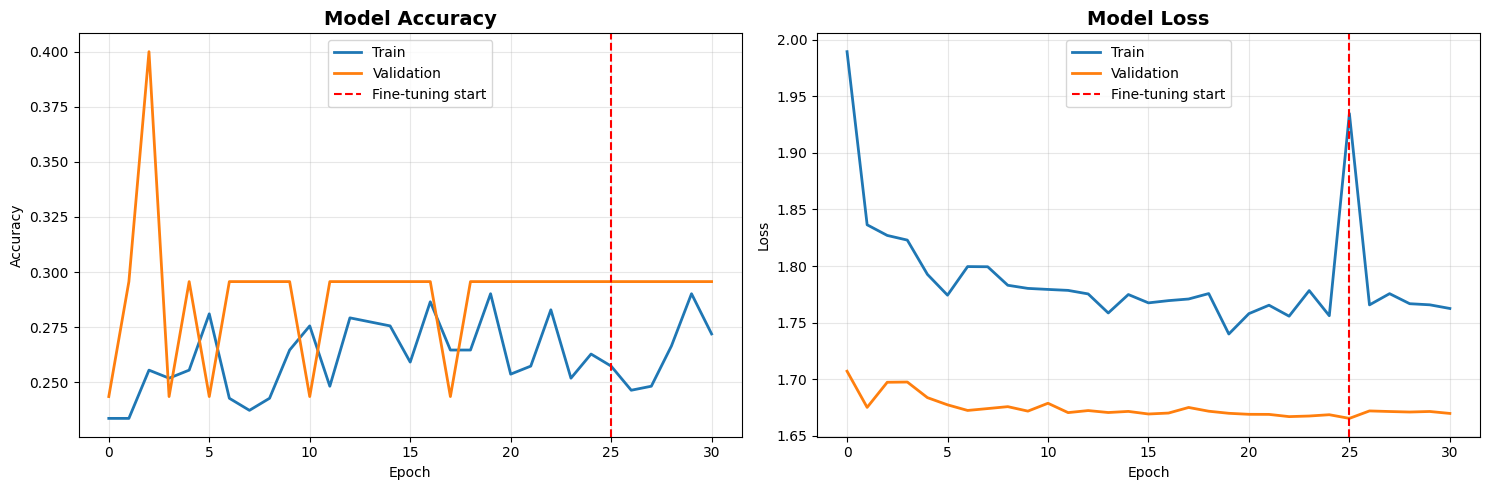

✅ Visualización completada


In [ ]:
# ============================================
# PASO 11: Visualizar Curvas de Entrenamiento
# ============================================

print("📈 Visualizando curvas de entrenamiento...")
print()

# Combinar historiales
history_combined = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss'],
}

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history_combined['accuracy'], label='Train', linewidth=2)
axes[0].plot(history_combined['val_accuracy'], label='Validation', linewidth=2)
axes[0].axvline(x=len(history_phase1.history['accuracy']), color='red', linestyle='--', label='Fine-tuning start')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history_combined['loss'], label='Train', linewidth=2)
axes[1].plot(history_combined['val_loss'], label='Validation', linewidth=2)
axes[1].axvline(x=len(history_phase1.history['loss']), color='red', linestyle='--', label='Fine-tuning start')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualización completada")

🔍 Generando matriz de confusión...



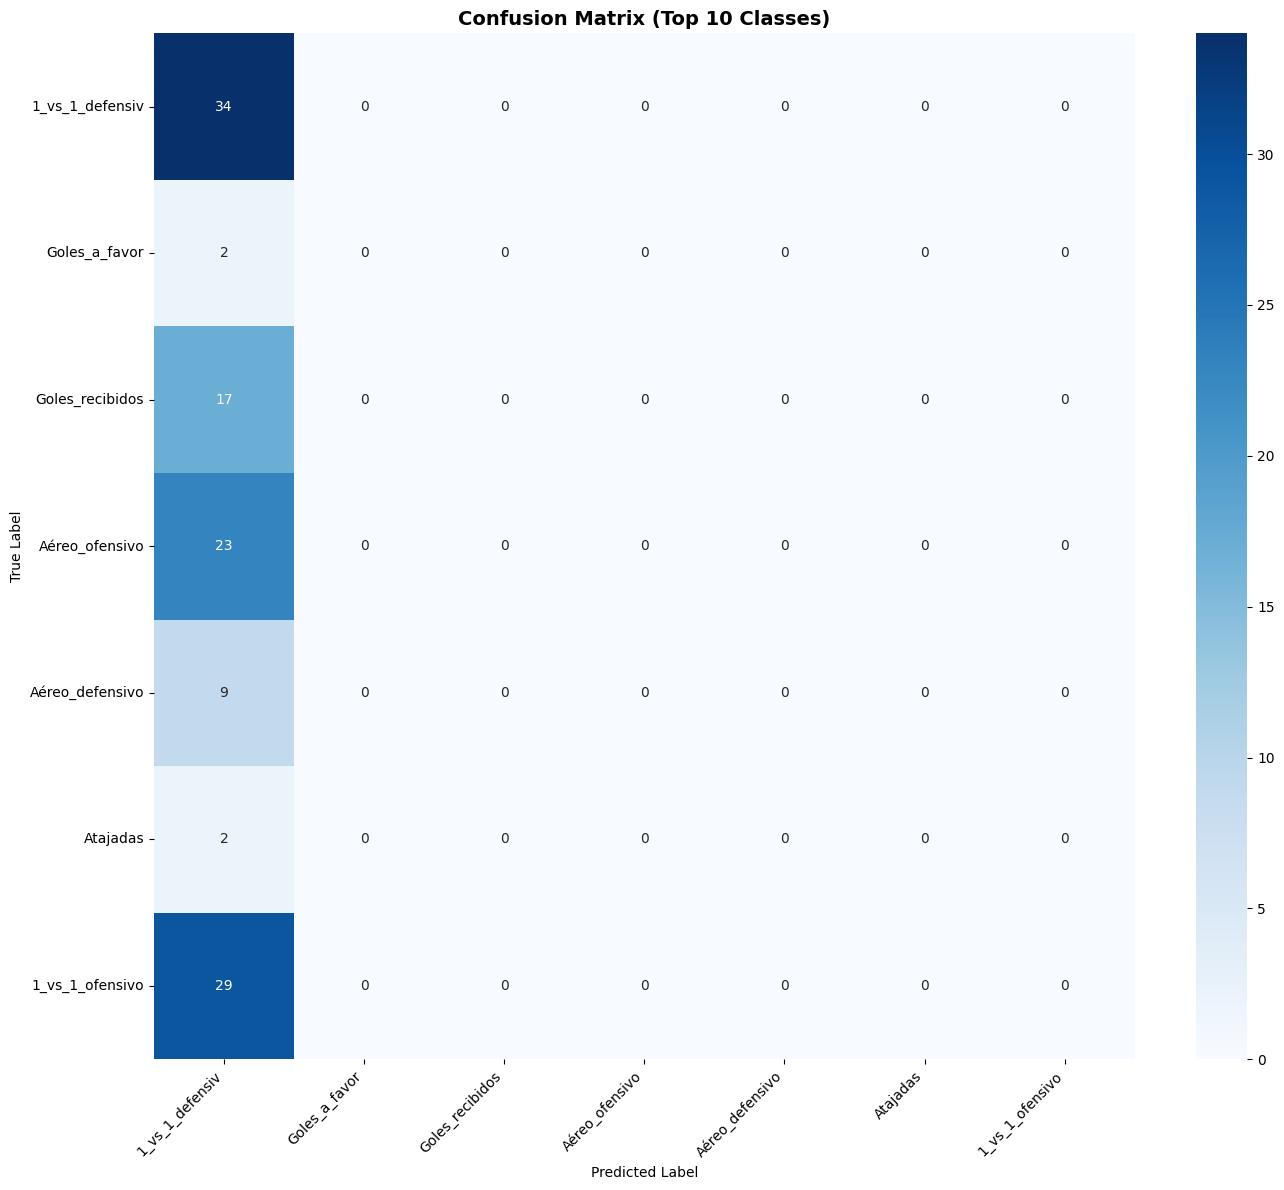


📊 Reporte de clasificación:



ValueError: Number of classes, 7, does not match size of target_names, 16. Try specifying the labels parameter

In [ ]:
# ============================================
# PASO 12: Matriz de Confusión
# ============================================

print("🔍 Generando matriz de confusión...")
print()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Obtener predicciones
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar (top 10 clases para claridad)
top_10_indices = np.argsort([cm[i, i] for i in range(len(cm))])[-10:][::-1]
cm_top10 = cm[top_10_indices][:, top_10_indices]
class_names_top10 = [class_names[i] for i in top_10_indices]

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_top10,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[c[:15] for c in class_names_top10],
    yticklabels=[c[:15] for c in class_names_top10]
)
plt.title('Confusion Matrix (Top 10 Classes)', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("\n📊 Reporte de clasificación:")
print()
print(classification_report(
    y_true, y_pred,
    target_names=class_names,
    zero_division=0
))

print("✅ Análisis completado")

In [ ]:
# ============================================
# PASO 13: Guardar Modelo y Metadatos
# ============================================

print("=" * 70)
print("💾 GUARDANDO MODELO")
print("=" * 70)
print()

# Guardar modelo en formato TensorFlow
print("📦 Guardando modelo...")
model.save('golanalytics_vision_model.keras')
print("✅ Modelo guardado: golanalytics_vision_model.keras")
print()

# Guardar clase names
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)
print("✅ Nombres de clases guardados: class_names.json")
print()

# Guardar metadatos
final_metadata = {
    'model_version': 'v1_vision',
    'trained_at': datetime.now().isoformat(),
    'framework': 'TensorFlow/Keras',
    'base_model': 'EfficientNetB0',
    'image_size': list(IMG_SIZE),
    'n_classes': n_classes,
    'class_names': class_names,
    'training': {
        'epochs_phase1': len(history_phase1.history['accuracy']),
        'epochs_phase2': len(history_phase2.history['accuracy']),
        'total_epochs': len(history_combined['accuracy']),
        'batch_size': BATCH_SIZE,
        'learning_rate_phase1': LEARNING_RATE,
        'learning_rate_phase2': LEARNING_RATE / 10,
    },
    'performance': {
        'test_accuracy': float(test_acc),
        'test_top3_accuracy': float(test_top3),
        'test_loss': float(test_loss),
        'best_val_accuracy': float(max(history_combined['val_accuracy'])),
    },
    'dataset': {
        'total_frames': metadata['total_frames'],
        'train_frames': metadata['splits']['train']['success'],
        'val_frames': metadata['splits']['val']['success'],
        'test_frames': metadata['splits']['test']['success'],
    }
}

with open('model_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(final_metadata, f, indent=2, ensure_ascii=False)

print("✅ Metadatos guardados: model_metadata.json")
print()

# Descargar archivos
from google.colab import files

print("📥 Descargando archivos...")
print("   (Estos archivos se descargarán a tu computadora)")
print()

files.download('golanalytics_vision_model.keras')
files.download('class_names.json')
files.download('model_metadata.json')

print()
print("=" * 70)
print("🎉 ¡ENTRENAMIENTO COMPLETADO!")
print("=" * 70)
print()
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Test Top-3 Accuracy: {test_top3*100:.2f}%")
print()
print("📦 Archivos descargados:")
print("   1. golanalytics_vision_model.keras")
print("   2. class_names.json")
print("   3. model_metadata.json")
print()
print("🚀 Siguiente paso: Integrar a tu aplicación")
print()
print("=" * 70)

💾 GUARDANDO MODELO

📦 Guardando modelo...
✅ Modelo guardado: golanalytics_vision_model.keras

✅ Nombres de clases guardados: class_names.json

✅ Metadatos guardados: model_metadata.json

📥 Descargando archivos...
   (Estos archivos se descargarán a tu computadora)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 ¡ENTRENAMIENTO COMPLETADO!

✅ Test Accuracy: 29.31%
✅ Test Top-3 Accuracy: 74.14%

📦 Archivos descargados:
   1. golanalytics_vision_model.keras
   2. class_names.json
   3. model_metadata.json

🚀 Siguiente paso: Integrar a tu aplicación



In [ ]:
# ============================================
# PASO 14: Prueba del Modelo (OPCIONAL)
# ============================================

print("🧪 PROBANDO MODELO CON EJEMPLOS")
print("=" * 70)
print()

# Tomar algunos ejemplos del test set
for images, labels in test_ds.take(1):
    predictions = model.predict(images[:9])

    plt.figure(figsize=(15, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        true_label = class_names[np.argmax(labels[i])]
        pred_label = class_names[np.argmax(predictions[i])]
        confidence = np.max(predictions[i]) * 100

        color = 'green' if true_label == pred_label else 'red'

        plt.title(
            f"True: {true_label[:15]}\n"
            f"Pred: {pred_label[:15]}\n"
            f"Conf: {confidence:.1f}%",
            color=color,
            fontsize=9
        )
        plt.axis("off")

    plt.suptitle('Predicciones del Modelo (Verde=Correcto, Rojo=Incorrecto)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("✅ Prueba completada")